# Demonstration of soScope working on negative binomial distribution

This is a demonstration of soScope analysis on simulated data with negative binomial distribution.

Bohan Li @ Deng ai Lab @ BUAA 2023.

Software provided as is under MIT License.

In [1]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

from soScope_model.train import two_step_train
from soScope_model.inference import infer

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_all(6172)

## Scene Preset

Experiment: Human intestine tissue resolution enhancement experiment.

Inputs: 369 “low-resolution” spots with aggregated gene expressions (X), morphological image features generated from a pretrained Inception-v3 model at high-resolution (Y), and spatial neighboring relations (A)

Outputs: Profiles of 2,649 “enhanced-resolution” spots corresponding to the 2,649 sequencing spots generated using Visium platform.

Genes analyzed: MT1G, FABP1, EPCAM in Epithelium region; CNN1, MYH11, TAGLN in Muscularis region; PTPRC, HLA-DRA, CD74 in Immune region.



In [2]:
# Train model
# vgae_experiment_dir: saving directory for pre-training stage.
# svae_experiment_dir: saving directory soScope training.
# data_dir: dataset directory contains necessary data mentioned above.
# vgae_config_file: model configuration for variational graph auto-encoder used in pre-training stage.
# svae_config_file: model configuration for soScope.
# device, checkpoint_every, backup_every, epochs: default training settings.
# num_neighbors: edges are built between every neighboring 6 nodes, not to be revised.
saved_model = two_step_train(logging=not None,
                             vgae_experiment_dir='experiments/VGAE_NB',
                             svae_experiment_dir='experiments/soScope_NB',
                             data_dir='DataSet/NB_demo/',
                             vgae_config_file='config/NB/VGAE.yml',
                             svae_config_file='config/NB/soScope.yml',
                             device='cuda',
                             checkpoint_every=1000,
                             backup_every=200,
                             epochs=[2500, 2500],
                             num_neighbors=6
                            )


Step 1
<class 'soScope_model.training.vgae.VGAETrainer_NB'>
===There are 346 nodes to train.===
Sub Data Loaded
We built edges between every neighboring 6 nodes
Spatial Data Loaded
Dataset loaded!
========== Initialization the graph encoder ============


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:34<00:00, 71.65it/s]


Step 2
<class 'soScope_model.training.svae_Global_NB.soScope_NB'>
========== Optimization of soScope ============


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:16<00:00, 32.85it/s]


In [4]:
# Inference enhanced expression
# experiment_dir: saving directory for inference stage.
# non_negative, device: default training settings.
# num_neighbors: edges are built between every neighboring 6 nodes, not to be revised.
# data_dir: dataset directory contains necessary data mentioned above.
# result_dir: saving directory for results.
infer(
        experiment_dir= 'experiments/soScope_NB',
        non_negative=True,
        num_neighbors=6,
        data_dir= 'DataSet/NB_demo/',
        result_dir='DataSet/NB_demo/',
        device='cuda',
        saved_model=saved_model
)

<class 'soScope_model.training.svae_Global_NB.soScope_NB'>
Pretrained Model Loaded!
use passed trainer!
We built edges between every neighboring 6 nodes
Spatial Data Loaded


In [5]:
# Visualization
# Load results from dist
# lr_count, position: merged data with positions contains column (x) and row (y) index.
# original_count, en_position: enhanced data with positions contains column (en_x) and row (en_y) index.
# hr_count: soScope data.
lr_count = np.load(f'DataSet/NB_demo/label.npy')
position = pd.read_csv(f'DataSet/NB_demo/colData.csv')
row = position['image_row'].tolist()
col = position['image_col'].tolist()

hr_count = np.load(f'DataSet/NB_demo/infer_subspot.npy')
en_position = pd.read_csv(f'DataSet/NB_demo/reordered_position.csv')
en_row = en_position['image_row'].tolist()
en_col = en_position['image_col'].tolist()

original_count_df = pd.read_csv(f'DataSet/NB_demo/original_count.csv', index_col=0)

original_count = original_count_df.values
gene_name = original_count_df.keys().tolist()

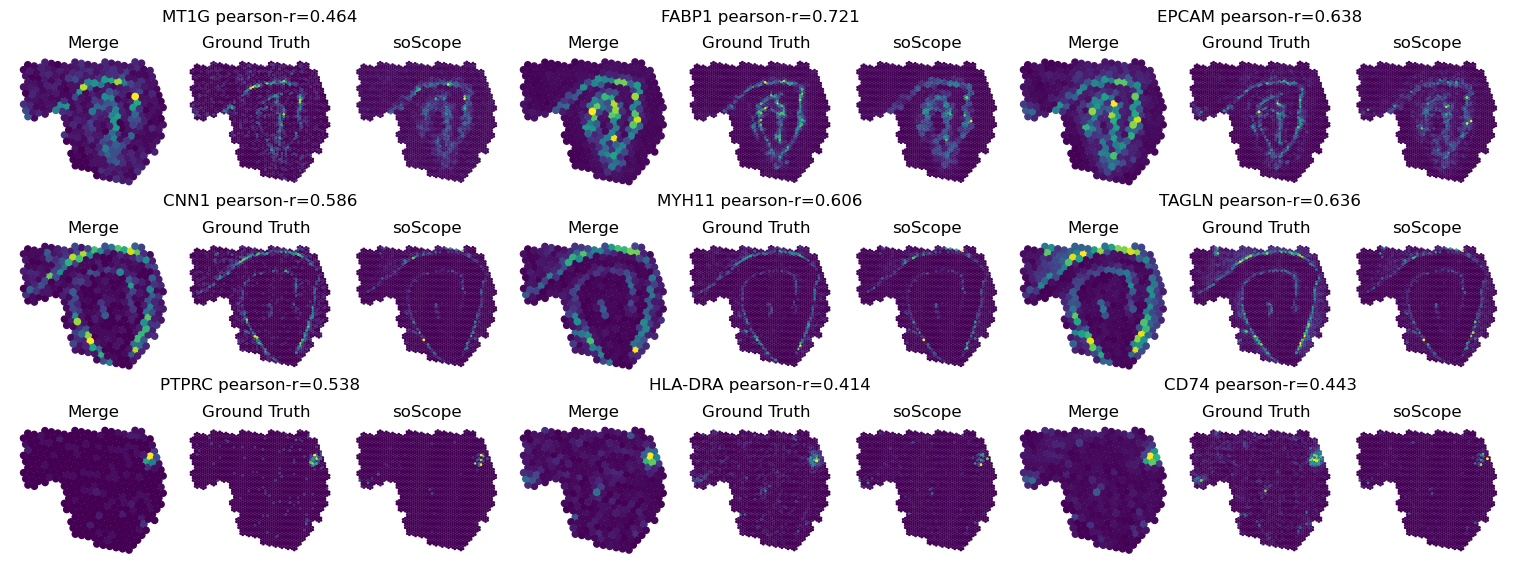

In [6]:
# Simulated resolution enhancement visualization. 
# Visualized data: top 9 variable genes, contains Epithelium, Muscularis and Immune region (3 variable genes for each region)
# pearson-r: pearson correlation score calculated from soScope predicted data and Ground Truth. 
# arrangment in subplot: merged data (left) at low resolution, ground truth data (middle) and scScope (right) predicted data at enhanced resolution

from scipy.stats import pearsonr

cmap = 'viridis'
idx=9
fig = plt.figure(figsize=(15, 5), dpi=100)
gene_names = ['MT1G', 'FABP1', 'EPCAM', 'CNN1', 'MYH11', 'TAGLN', 'PTPRC', 'HLA-DRA', 'CD74']

for idx in range(9):
    pearson_r, _ = pearsonr(original_count[:, idx], hr_count[:, idx])
    gene_name = gene_names[idx]
    
    # merged data visualization
    ax = fig.add_subplot(3, 9, 3*idx+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(row, col, s=20,
                marker = 'o',
                c=lr_count[:, idx],
                cmap=cmap,
                )
    plt.title('Merge', y=1)
    
    # ground truth data visualization
    ax = fig.add_subplot(3, 9, 3*idx+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_row, en_col, s=1,
                marker='o',
                c=original_count[:, idx],
                cmap=cmap,
                )
    plt.title(gene_name+' pearson-r={:.3f}'.format(pearson_r),y=1.2)
    plt.title('Ground Truth', loc='left',y=1, x=0.15)
    
    # soScope predicted data visualization
    ax = fig.add_subplot(3, 9, 3*idx+3)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_row, en_col, s=1,
                marker='o',
                c=hr_count[:, idx],
                cmap=cmap,
                )
    plt.title('soScope', y=1)
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()